In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

data_path = r"C:\Users\itayg\Documents\MonetGAN\Data"

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\itayg\Documents\MonetGAN\Data\monet_generated\057d83cdee.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\000c1e3bff.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\011835cfbf.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\0260d15306.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\049e293b93.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\05144e306f.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\052a77c020.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\058f878b7c.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\05b493ff42.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\064487d630.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\066fe4cbaa.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\07fcaee35f.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\09b76b6471.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\0a5075d42a.jpg
C:\Users\itayg\Documents\MonetGAN\Data\monet_jpg\0bd913dbc7.jpg
C:\Users\itayg\Documents\MonetGAN\

In [2]:
monet_path = 'C:/Users/itayg/Documents/MonetGAN/Data/monet_jpg/'
photo_path = 'C:/Users/itayg/Documents/MonetGAN/Data/photo_jpg/'

In [3]:
transform = transforms.Compose([
    transforms.Resize((256,256), interpolation=Image.BICUBIC),transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
])

In [4]:
class MonetDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_files = [os.path.join(monet_dir, f) for f in os.listdir(monet_dir)]
        self.photo_files = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]
        self.transform = transform

    def __len__(self):
        return min(len(self.monet_files), len(self.photo_files))  # Match dataset size

    def __getitem__(self, idx):
        monet_img = Image.open(self.monet_files[idx]).convert("RGB")
        photo_img = Image.open(self.photo_files[idx]).convert("RGB")

        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)

        return monet_img, photo_img
        

In [5]:
#Load the data
dataset = MonetDataset(monet_path, photo_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import VGG19_Weights

class VGGPerceptualLoss(nn.Module):
    def __init__(self, layers=('relu3_3',), resize=True):
        super(VGGPerceptualLoss, self).__init__()
        self.vgg = self._build_vgg19_extractor(layers)
        self.criterion = nn.L1Loss()
        self.resize = resize
        #ImagNet mean and std
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

    def _build_vgg19_extractor(self, layers):
        vgg_pretrained = models.vgg19(weights=VGG19_Weights.DEFAULT).features
        vgg_layers = {
            'relu1_1':1,
            'relu1_2':3,
            'relu2_1':6,
            'relu2_2':8,
            'relu3_1':11,
            'relu3_2':13,
            'relu3_3':15,
            'relu4_1':20,
        }
        max_idx = max([vgg_layers[layer]for layer in layers])
        model = nn.Sequential(*[vgg_pretrained[i]for i in range(max_idx + 1)])
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        return model
        
    def normalize_for_vgg(self, x):
        # convert from [-1,1] to [0,1]
        x = (x+1.0) / 2.0
        
        return (x - self.mean.to(x.device)) /self.std.to(x.device)
        
    def forward(self,x,y):
        if self.resize:
            x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            y = nn.functional.interpolate(y, size=(224, 224), mode='bilinear', align_corners=False)

        x = self.normalize_for_vgg(x)
        y = self.normalize_for_vgg(y)
        
        return self.criterion(self.vgg(x), self.vgg(y))

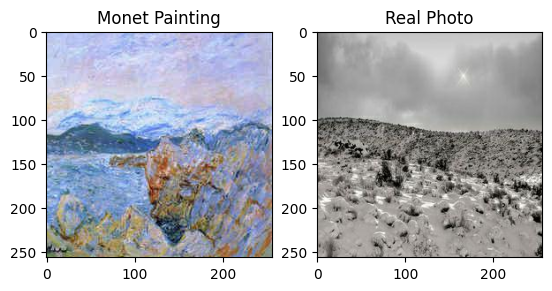

In [7]:
#Let's visualize the data
import matplotlib.pyplot as plt
sample_monet, sample_photo = next(iter(dataloader))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sample_monet.squeeze().permute(1, 2, 0) * 0.5 + 0.5)
ax[0].set_title("Monet Painting")
ax[1].imshow(sample_photo.squeeze().permute(1, 2, 0) * 0.5 + 0.5)
ax[1].set_title("Real Photo")
plt.show()

Generator class implementation (U-Net based)

In [8]:
import torch
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=0),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # ResNet blocks
        self.resnet_blocks = nn.Sequential(*[ResBlock(256) for _ in range(9)])

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.resnet_blocks(x)
        x = self.decoder(x)
        return x


In [9]:
def init_weights(net, init_gain=0.02):
    for m in net.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, init_gain)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif isinstance(m, nn.InstanceNorm2d):
            if m.weight is not None:
                nn.init.normal_(m.weight.data, 1.0, init_gain)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)


Discriminator class implemintation

In [10]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def conv_block(in_c, out_c, normalize=True, apply_dropout=False):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if apply_dropout:
                layers.append(nn.Dropout2d(0.3))  # or 0.5
            return layers

        self.model = nn.Sequential(
            *conv_block(in_channels, 64, normalize=False),      # no norm/dropout
            *conv_block(64, 128, apply_dropout=True),           # add dropout here
            *conv_block(128, 256, apply_dropout=True),          # and here
            nn.Conv2d(256, 1, 4, padding=1)  # Output 1-channel "real/fake" map
        )

    def forward(self, x):
        return self.model(x)


In [11]:
import torch
import matplotlib.pyplot as plt

def denormalize(tensor):
    """
    Converts a tensor from [-1, 1] to [0, 1] for display.
    Expects tensor shape (C, H, W) or (B, C, H, W).
    """
    tensor = tensor * 0.5 + 0.5
    return tensor.clamp(0, 1)

def show_generated_samples(generator, real_photo, epoch):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():
        fake_monet = generator(real_photo.to(device))  # Generate Monet-style image

    # Get first image in batch
    real_photo = real_photo[0].cpu().detach()
    fake_monet = fake_monet[0].cpu().detach()

    # De-normalize from [-1, 1] → [0, 1]
    real_photo = denormalize(real_photo).permute(1, 2, 0)
    fake_monet = denormalize(fake_monet).permute(1, 2, 0)

    # Plot images side by side
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(real_photo.numpy())
    ax[0].set_title("Real Photo")
    ax[0].axis("off")

    ax[1].imshow(fake_monet.numpy())
    ax[1].set_title(f"Generated Monet (Epoch {epoch})")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

In [12]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        result = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                result.append(element)
            else:
                if torch.rand(1).item() > 0.5:
                    idx = torch.randint(0, len(self.data), (1,)).item()
                    result.append(self.data[idx].clone())
                    self.data[idx] = element
                else:
                    result.append(element)
        return torch.cat(result)


In [13]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

Epoch [195/195]: 100%|██████████| 300/300 [00:21<00:00, 14.26it/s, D_loss_A=0.133, D_loss_B=0.0816, G_loss_A2B=0.351, G_loss_B2A=0.336]


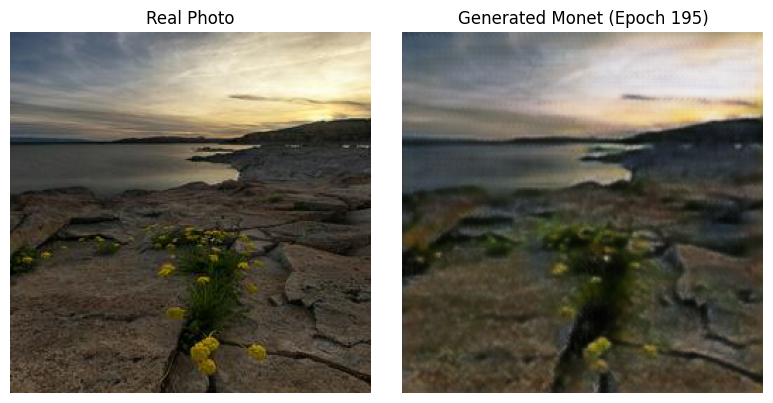

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# Device setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Generator (Photo → Monet) and Discriminator (Monet)
G_A2B = Generator().to(device)  # Photo → Monet
init_weights(G_A2B)
G_B2A = Generator().to(device)  # Monet → Photo
init_weights(G_B2A)
D_A = Discriminator().to(device)  # Monet Discriminator
D_B = Discriminator().to(device)  # Photo Discriminator

# Loss functions
criterion_GAN = nn.MSELoss()  # Adversarial loss
criterion_cycle = nn.L1Loss()  # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss
# Perceptual loss
perceptual_loss_fn = VGGPerceptualLoss().to(device)
LAMBDA_VGG = 0

# Optimizers
optimizer_G = optim.Adam(
    list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training parameters
EPOCHS = 195
LAMBDA_CYCLE = 10  # Weight for cycle consistency loss (adjusted)
LAMBDA_IDENTITY = 1.5  # Weight for identity loss (adjusted)

# Learning rate schedulers (linear decay after half of total epochs)
lr_lambda = lambda epoch: 1.0 - max(0, epoch - EPOCHS // 2) / float(EPOCHS // 2)
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)

# Training Loop
for epoch in range(EPOCHS):
    loop = tqdm(dataloader, leave=True)
    
    for i, (real_A, real_B) in enumerate(loop):  # real_A: photo, real_B: Monet
        real_A = real_A.to(device)  # Real photo (Domain A)
        real_B = real_B.to(device)  # Real Monet painting (Domain B)

        ### ---- TRAIN GENERATOR (Photo -> Monet) ---- ###
        optimizer_G.zero_grad()
        #Forward passes for both directions
        fake_A = G_A2B(real_A)
        fake_B = G_B2A(real_B)

        # Discriminator predictions
        pred_fake_B = D_A(fake_B)
        pred_fake_A = D_B(fake_A)

        # Generator losses
        loss_GAN_A2B = criterion_GAN(pred_fake_B, torch.ones_like(pred_fake_B))
        loss_GAN_B2A = criterion_GAN(pred_fake_A, torch.ones_like(pred_fake_A))

        #Identity losses
        identity_B = G_A2B(real_B)
        identity_A = G_B2A(real_A)
        loss_identity_B = criterion_identity(real_B, identity_B)*LAMBDA_IDENTITY
        loss_identity_A = criterion_identity(real_A, identity_A)*LAMBDA_IDENTITY

        # Cycle consistency losses
        rec_A = G_B2A(fake_B.detach())
        rec_B = G_A2B(fake_A.detach())
        loss_cycle_A = criterion_cycle(real_A, rec_A)*LAMBDA_CYCLE
        loss_cycle_B = criterion_cycle(real_B, rec_B)*LAMBDA_CYCLE
        # Perceptual loss
        loss_vgg = perceptual_loss_fn(fake_B, real_B)*LAMBDA_VGG

        # Total generator loss
        loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_identity_B + loss_identity_A + loss_cycle_A + loss_cycle_B + loss_vgg
        loss_G.backward()
        optimizer_G.step()

        ### ---- TRAIN DISCRIMINATOR (Monet) ---- ###
        optimizer_D_A.zero_grad()

        # Discriminator Loss: Real Monet
        pred_real_B = D_A(real_B)
        loss_D_real_B = criterion_GAN(pred_real_B, torch.full_like(pred_real_B, 0.9))

        # Discriminator Loss: Fake Monet
        #pred_fake_B = D_A(fake_B.detach())  # Stop gradient on generator
        fake_B_buffered = fake_B_buffer.push_and_pop(fake_B)
        pred_fake_B = D_A(fake_B_buffered)
        loss_D_fake_B = criterion_GAN(pred_fake_B, torch.zeros_like(pred_fake_B))

        # Total Discriminator Loss for D_A (Monet Discriminator)
        loss_D_A = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        ### ---- TRAIN DISCRIMINATOR (Photo) ---- ###
        optimizer_D_B.zero_grad()

        # Discriminator Loss: Real Photo
        pred_real_A = D_B(real_A)
        loss_D_real_A = criterion_GAN(pred_real_A, torch.full_like(pred_real_A, 0.9))

        # Discriminator Loss: Fake Photo
        #pred_fake_A = D_B(fake_A.detach())  # Stop gradient on generator
        fake_A_buffered = fake_A_buffer.push_and_pop(fake_A)
        pred_fake_A = D_B(fake_A_buffered)
        loss_D_fake_A = criterion_GAN(pred_fake_A, torch.zeros_like(pred_fake_A))

        # Total Discriminator Loss for D_B (Photo Discriminator)
        loss_D_B = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        ### ---- Update Progress Bar ---- ###
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(
            G_loss_A2B=loss_GAN_A2B.item(), G_loss_B2A=loss_GAN_B2A.item(), D_loss_A=loss_D_A.item(), D_loss_B=loss_D_B.item()
        )
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save and show generated samples periodically (every 5 epochs, for example)
    if (epoch + 1) % 195 == 0:
        _, real_photo_sample = next(iter(dataloader))
        show_generated_samples(G_A2B, real_photo_sample[:1], epoch + 1)
    
    # Save checkpoints every 10 epochs
    if (epoch + 1) % 195 == 0:
        torch.save(G_A2B.state_dict(), f"generator_photo2monet_epoch{epoch+1}.pth")
        torch.save(G_B2A.state_dict(), f"generator_monet2photo_epoch{epoch+1}.pth")
        torch.save(D_A.state_dict(), f"discriminator_monet_epoch{epoch+1}.pth")
        torch.save(D_B.state_dict(), f"discriminator_photo_epoch{epoch+1}.pth")


In [ ]:
test_input = torch.ones(1, 3, 256, 256) * 0.0  # Or use 0.5 if normalized
test_input = test_input.to(device)
show_generated_samples(G_A2B, test_input, 20)

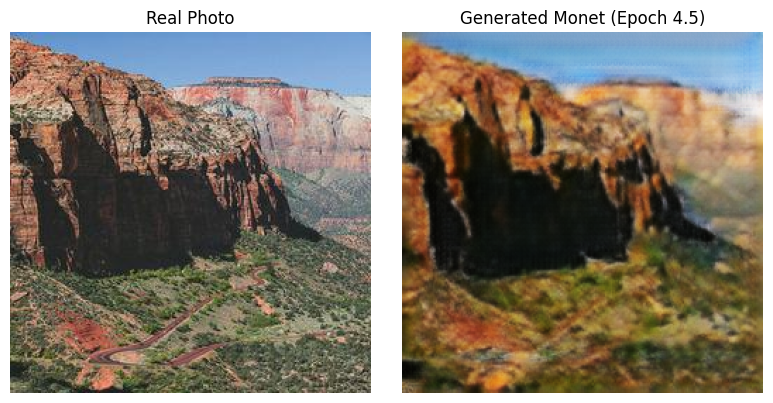

In [15]:
from PIL import Image

test_input_path = 'C:/Users/itayg/Documents/MonetGAN/Data/photo_jpg/dd036adfe5.jpg'
test_input = Image.open(test_input_path).convert('RGB')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5), (0.5))
])
test_input = transform(test_input).unsqueeze(0)
test_input = test_input.to(device)
show_generated_samples(G_A2B, test_input, 4.5)

In [ ]:
# Generate and save images
from torchvision.utils import save_image
for i in range(100):
    _, real_photo_sample = next(iter(dataloader))
    fake_image = G_A2B(real_photo_sample.to(device)).cpu()
    output_dir = "/kaggle/working/"
    save_path = os.path.join(output_dir, f"image_{i:04}.png")
    save_image(fake_image, save_path, normalize=True)

with ZipFile(zip_filename, 'w') as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, output_dir))    